In [ ]:
#@title Copyright 2020 Google LLC. Double-click for license information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Representation with a Feature Cross

In this exercise, you'll experiment with different ways to represent features.

## Learning Objectives:

After doing this Colab, you'll know how to:

  * Use TensorFlow [preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) to represent features in different ways.
  * Represent features as [bins](https://developers.google.com/machine-learning/glossary/#bucketing).
  * Cross bins to create a [feature cross](https://developers.google.com/machine-learning/glossary/#feature_cross).

## The Dataset
  
Like several of the previous Colabs, this exercise uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

## Call the import statements

The following code imports the necessary code to run the code in the rest of this Colaboratory.

In [1]:
#@title Load the imports

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10 # 顯示 DataFrame 時顯示的最大行數為 10 行。
pd.options.display.float_format = "{:.1f}".format # 設置 pandas 顯示浮點數時的格式為小數點後 1 位。

tf.keras.backend.set_floatx('float32') # 將 TensorFlow Keras 的默認數據類型設置為 float32，這樣可以節省內存並提高計算效率。

print("Imported the modules.")

Imported the modules.


## Load, scale, and shuffle the examples

The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set

The code cell then scales the `median_house_value` to a more human-friendly range and then shuffles the examples.

In [2]:
# Load the dataset
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Scale the labels
scale_factor = 1000.0
# Scale the training set's label.
train_df["median_house_value"] /= scale_factor

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

# Shuffle the examples
train_df = train_df.reindex(np.random.permutation(train_df.index))

In [ ]:
print(train_df)
print(test_df)

## Represent latitude and longitude as floating-point values

Previous Colabs trained on only a single feature or a single synthetic feature. By contrast, this exercise trains on two features using **Input layers**.

A neighborhood's location is typically the most important feature in determining a house's value. The California Housing dataset provides two features, `latitude` and `longitude` that identify each neighborhood's location.

The following code cell defines two [`tf.keras.Input`](https://keras.io/api/layers/core_layers/input/) layers, one to represent `latitude` and another one to represent `longitude`, both as floating-point values.

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented.


### tf.keras.layers.Input：用於創建 Keras 模型的輸入層。這些層定義了模型接受的數據的形狀和數據類型。  
* shape=(1,)：指定輸入的形狀。在這裡，形狀為 (1,) 意味著每個輸入都是一個一維的浮點數。這適用於單一的數值輸入，例如經度或緯度。  
* dtype=tf.float32：指定數據類型為 float32。  
* name='latitude' 和 name='longitude'：分別給每個輸入層指定名稱，以便在構建和調試模型時能夠識別它們。

In [17]:
# Keras Input tensors of float values.
inputs = {
    'latitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='latitude'),
    'longitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='longitude')
}

In [4]:
inputs.values()

dict_values([<KerasTensor shape=(None, 1), dtype=float32, sparse=None, name=latitude>, <KerasTensor shape=(None, 1), dtype=float32, sparse=None, name=longitude>])

In [6]:
inputs['latitude']

<KerasTensor shape=(None, 1), dtype=float32, sparse=None, name=latitude>

In [8]:
list(inputs.values())

[<KerasTensor shape=(None, 1), dtype=float32, sparse=None, name=latitude>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=None, name=longitude>]

## Define functions that create and train a model, and a plotting function

The following code defines three functions:

  * `create_model`, which tells TensorFlow to build a linear regression model based on the inputs and outputs provided.
  * `train_model`, which will ultimately train the model from training set examples.
  * `plot_the_loss_curve`, which generates a loss curve.

In [12]:
#@title Define functions to create and train a model, and a plotting function

# my_inputs：模型的輸入層或層序列
# my_outputs：模型的輸出層或層序列
# my_learning_rate：學習率，用於優化器
def create_model(my_inputs, my_outputs, my_learning_rate):

  # tf.keras.Model：建立一個 Keras 模型，指定 inputs 和 outputs。這個模型將根據提供的輸入層和輸出層組合起來
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Construct the layers into a model that TensorFlow can execute.
  # optimizer：設定模型的優化器
  # loss：損失函數，這裡使用的是 mean_squared_error（均方誤差）
  # metrics：指標，用於在訓練過程中評估模型的表現。在這裡使用的是 tf.keras.metrics.RootMeanSquaredError()（均方根誤差），用於衡量模型預測的準確性
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
      loss="mean_squared_error",
      metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model # 返回編譯好的模型


def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  features = {name:np.array(value) for name, value in dataset.items()} # 將數據集中的每個特徵轉換為 NumPy 數組
  print("!!!!!!!!!!  test, features:",features)
  label = np.array(features.pop(label_name)) # 將數據集中指定名稱的標籤提取出來，並從 features 字典中移除
  print("!!!!!!!!!!  test, label:",label)
  # model.fit：使用給定的特徵和標籤訓練模型
  # batch_size：每次更新模型的樣本數
  # epochs：訓練的總迭代次數
  # shuffle=True：在每個 epoch 開始時隨機打亂數據
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)
  print("!!!!!!!!!!  test, history:",history)

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  print("!!!!!!!!!!  test, epochs:",epochs)

  # Isolate the mean absolute error for each epoch.
  hist = pd.DataFrame(history.history)
  print("!!!!!!!!!!  test, hist:",hist)
  rmse = hist["root_mean_squared_error"]
  print("!!!!!!!!!!  test, rmse:",rmse)

  return epochs, rmse # 返回訓練過程中每個 epoch 的數字和對應的均方根誤差（RMSE），以便於後續的分析和可視化。


def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend() # 顯示圖例
  plt.ylim([rmse.min()*0.94, rmse.max()* 1.05]) # 設置 Y 軸的顯示範圍，略微擴展了 RMSE 的最小值和最大值
  plt.show()

print("Defined the create_model, train_model, and plot_the_loss_curve functions.")

Defined the create_model, train_model, and plot_the_loss_curve functions.


## Train the model with floating-point representations

The following code cell calls the functions you just created to train, plot, and evaluate a model.

!!!!!!!!!!  test, features: {'longitude': array([-121.33, -118.15, -117.93, ..., -121.92, -118.69, -118.08]), 'latitude': array([37.97, 34.06, 33.67, ..., 36.56, 34.21, 33.91]), 'housing_median_age': array([43., 28., 27., ..., 39., 10., 36.]), 'total_rooms': array([1511., 3855., 3512., ..., 2144., 3663., 1551.]), 'total_bedrooms': array([292., 922., 472., ..., 538., 409., 297.]), 'population': array([ 721., 2517., 1391., ...,  749., 1179., 1100.]), 'households': array([320., 874., 481., ..., 419., 371., 322.]), 'median_income': array([ 3.5703,  3.505 ,  8.1001, ...,  2.7039, 12.542 ,  5.1187]), 'median_house_value': array([ 87.4  , 204.3  , 336.5  , ..., 364.   , 500.001, 168.1  ])}
!!!!!!!!!!  test, label: [ 87.4   204.3   336.5   ... 364.    500.001 168.1  ]
Epoch 1/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 24064.7832 - root_mean_squared_error: 154.6744
Epoch 2/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 15730.2734 - root_mean_squared_error: 125.4003
Epoch 3/30
17

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ latitude            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ longitude           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 2)         │          0 │ latitude[0][0],   │
│ (Concatenate)       │                   │            │ longitude[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer (Dense) │ (None, 1)         │          3 │ concatenate_15[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8 (36.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5 (24.00 B)

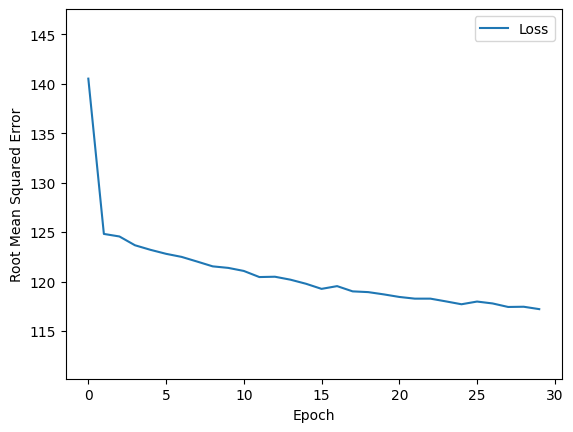


: Evaluate the new model against the test set:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13269.8125 - root_mean_squared_error: 115.1535


[13539.2822265625, 116.3584213256836]

In [27]:
# The following variables are the hyperparameters.
learning_rate = 0.05
epochs = 30
batch_size = 100
label_name = 'median_house_value'

# The two Input layers are concatenated so they can be passed as a single tensor to a Dense layer.
# tf.keras.layers.Concatenate()：將 latitude 和 longitude 這兩個輸入層按列連接，形成一個單一的張量。
preprocessing_layer = tf.keras.layers.Concatenate()(list(inputs.values()))
# 添加一個全連接層，輸出一個數值。這裡設置 units=1 表示該層有一個輸出單元。
dense_output = layers.Dense(units=1, name='dense_layer')(preprocessing_layer)

outputs = {
  'dense_output': dense_output
}

# Create and compile the model's topography.
# my_model = create_model(inputs=[input_longitude, input_latitude], outputs, learning_rate)
my_model = create_model(list(inputs.values()), list(outputs.values()), learning_rate)

# To view a PNG of this model's layers, uncomment the call to
# `tf.keras.utils.plot_model` below. After running this code cell, click
# the file folder on the left, then the `my_model.png` file.
# tf.keras.utils.plot_model(my_model, "my_model.png", show_shapes=True)

# my_model.summary(expand_nested=True)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

# Print out the model summary.
my_model.summary(expand_nested=True)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## Task 1: Why aren't floating-point values a good way to represent latitude and longitude?  
 用浮點數值來表示緯度和經度沒有太多預測能力。例如，緯度為 35 的地區不一定比緯度為 36 的地區貴 36/35 倍。  
 用這些原始數值建立基準線後的數據更加有用。


Are floating-point values a good way to represent `latitude` and `longitude`?

In [35]:
inputs['latitude']

<KerasTensor shape=(None, 1), dtype=float32, sparse=None, name=latitude>

## Represent latitude and longitude in buckets

The following code cell represents latitude and longitude in buckets (bins). Each bin represents all the neighborhoods within a single degree. For example,
neighborhoods at latitude 35.4 and 35.8 are in the same bucket, but neighborhoods in latitude 35.4 and 36.2 are in different buckets.

The model will learn a separate weight for each bucket. For example, the model will learn one weight for all the neighborhoods in the "35" bin, a different weight for neighborhoods in the "36" bin, and so on. This representation will create approximately 20 buckets:

  * 10 buckets for `latitude`.
  * 10 buckets for `longitude`.

In [28]:
resolution_in_degrees = 1.0

# Create a list of numbers representing the bucket boundaries for latitude.
# 緯度桶邊界的列表
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])),
                                     int(max(train_df['latitude'])),
                                     resolution_in_degrees))
print("latitude boundaries: " + str(latitude_boundaries))

# Create a Discretization layer to separate the latitude data into buckets.
# 創建一個 Discretization 層來將緯度數據分割
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude')(inputs.get('latitude'))

# Number of categories is the length of latitude_boundaries plus one.
# 類別數量是 latitude_boundaries 的長度加一
# 使用 CategoryEncoding 層將這些 buckets 編碼為 one-hot 表示
latitude = tf.keras.layers.CategoryEncoding(
    num_tokens=len(latitude_boundaries) + 1,
    output_mode='one_hot',
    name='category_encoding_latitude')(latitude)

# ********************************************************************************************************
# Create a list of numbers representing the bucket boundaries for longitude.
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])),
                                      int(max(train_df['longitude'])),
                                      resolution_in_degrees))

print("longitude boundaries: " + str(longitude_boundaries))

# Create a Discretization layer to separate the longitude data into buckets.
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude')(inputs.get('longitude'))

# Number of categories is the length of longitude_boundaries plus one.
longitude = tf.keras.layers.CategoryEncoding(
    num_tokens=len(longitude_boundaries) + 1,
    output_mode='one_hot',
    name='category_encoding_longitude')(longitude)

# ********************************************************************************************************
# Concatenate latitude and longitude into a single tensor as input for the Dense layer.
# 將緯度和經度連接成一個單一的張量，作為 Dense 層的輸入
# tf.keras.layers.Concatenate 是 Keras 中的一個層，用於將多個張量（tensors）沿指定軸連接在一起
# latitude 和 longitude 是經過 Discretization 和 CategoryEncoding 層處理後的張量，這些張量被傳遞給 Concatenate 層
# Concatenate 層將這兩個張量連接在一起，默認情況下是在最後一個軸上（axis=-1）
concatenate_layer = tf.keras.layers.Concatenate()([latitude, longitude])

# ********************************************************************************************************
# tf.keras.layers.Dense 是 Keras 中的一個全連接層（也稱為密集層），該層會為每個輸入單位連接到每個輸出單位。這是一個常用的層，用於實現線性變換
# units=1：表示該層的輸出單元數量。這裡設置為 1，表示希望輸出一個值
# name='dense_layer'：為該層指定一個名稱，方便以後引用和檢查
# (concatenate_layer)：將前面 Concatenate 層的輸出作為 Dense 層的輸入
dense_output = layers.Dense(units=1, name='dense_layer')(concatenate_layer)

# ********************************************************************************************************
# Define an output dictionary we'll send to the model constructor.
#  Keras 模型中，輸入和輸出可以是字典形式，這樣可以更靈活地處理多輸入多輸出模型
# outputs 是一個字典，鍵 'dense_output' 對應的值是前面 Dense 層的輸出
# 這樣定義有助於在構造模型時清晰地指定模型的輸出
outputs = {
  'dense_output': dense_output
}

latitude boundaries: [32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0]
longitude boundaries: [-124.0, -123.0, -122.0, -121.0, -120.0, -119.0, -118.0, -117.0, -116.0, -115.0]


## Train the model with bucket representations

Run the following code cell to train the model with bucket representations rather than floating-point representations:

!!!!!!!!!!  test, features: {'longitude': array([-121.33, -118.15, -117.93, ..., -121.92, -118.69, -118.08]), 'latitude': array([37.97, 34.06, 33.67, ..., 36.56, 34.21, 33.91]), 'housing_median_age': array([43., 28., 27., ..., 39., 10., 36.]), 'total_rooms': array([1511., 3855., 3512., ..., 2144., 3663., 1551.]), 'total_bedrooms': array([292., 922., 472., ..., 538., 409., 297.]), 'population': array([ 721., 2517., 1391., ...,  749., 1179., 1100.]), 'households': array([320., 874., 481., ..., 419., 371., 322.]), 'median_income': array([ 3.5703,  3.505 ,  8.1001, ...,  2.7039, 12.542 ,  5.1187]), 'median_house_value': array([ 87.4  , 204.3  , 336.5  , ..., 364.   , 500.001, 168.1  ])}
!!!!!!!!!!  test, label: [ 87.4   204.3   336.5   ... 364.    500.001 168.1  ]
Epoch 1/35
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - loss: 54426.2812 - root_mean_squared_error: 233.2417
Epoch 2/35
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 45765.6914 - root_mean_squared_error: 213.9220
Epoch 3/35


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ latitude            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ longitude           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discretization_lat… │ (None, 1)         │          0 │ latitude[0][0]    │
│ (Discretization)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discretization_lon… │ (None, 1)         │          0 │ longitude[0][0]   │
│ (Discretization)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_encoding_… │ (None, 10)        │          0 │ discretization_l… │
│ (CategoryEncoding)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_encoding_… │ (None, 11)        │          0 │ discretization_l… │
│ (CategoryEncoding)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 21)        │          0 │ category_encodin… │
│ (Concatenate)       │                   │            │ category_encodin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer (Dense) │ (None, 1)         │         22 │ concatenate_16[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46 (188.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24 (100.00 B)

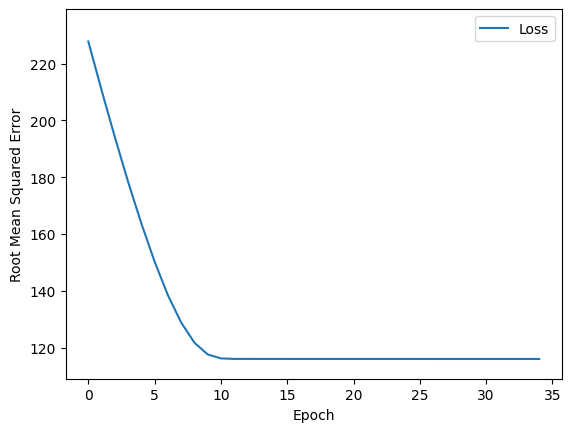


: Evaluate the new model against the test set:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 12339.5527 - root_mean_squared_error: 111.0289


[12809.73046875, 113.1800765991211]

In [30]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model.
my_model = create_model(list(inputs.values()), list(outputs.values()), learning_rate)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

# Print out the model summary.
my_model.summary(expand_nested=True)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## Task 2: Did buckets outperform floating-point representations?  

Compare the model's `root_mean_squared_error` values for the two representations (floating-point vs. buckets)?  Which model produced lower losses?  
Bucket representation outperformed floating-point representations.

## Task 3: What is a better way to represent location?

Buckets are a big improvement over floating-point values. Can you identify an even better way to identify location with `latitude` and `longitude`?  
將位置表示為特徵交叉（feature cross）應該會產生更好的結果。

在任務 2 中，你一維的 bucket 表示緯度，用另一組一維的 bucket 表示經度。然而，真實世界中的位置存在於二維空間。因此，你應該將位置表示為二維特徵交叉。也就是說，你將 10 個左右的緯度 bucket 和 10 個左右的經度 bucket 交叉，創建一個 100 個網格單元的格子。

模型將為每個單元學習獨立的權重。  

**特徵交叉（Feature Cross）**
* 概念：特徵交叉是一種將多個特徵組合在一起形成新的特徵的方法。在這裡，將緯度和經度交叉形成一個二維網格，每個網格單元代表一個特定的位置區域。

* 優點：特徵交叉能更精確地捕捉到位置特徵，因為它考慮了緯度和經度的聯合影響，而不是單獨考慮每個維度。這能使模型學習到更細緻的地理模式。

## Represent location as a feature cross

The following code cell represents location as a feature cross. That is, the following code cell first creates buckets and then crosses the latitude and longitude features using a `HashedCrossing` layer.



In [38]:
resolution_in_degrees = 1
# resolution_in_degrees = 0.4

# Create a list of numbers representing the bucket boundaries for latitude.
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])),
                                     int(max(train_df['latitude'])),
                                     resolution_in_degrees))

# Create a Discretization layer to separate the latitude data into buckets.
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude')(inputs.get('latitude'))

# Create a list of numbers representing the bucket boundaries for longitude.
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])),
                                      int(max(train_df['longitude'])),
                                      resolution_in_degrees))

# Create a Discretization layer to separate the longitude data into buckets.
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude')(inputs.get('longitude'))

# ********************************************************************************************************
# Cross the latitude and longitude features into a single one-hot vector.
# 將緯度和經度特徵交叉成一個單一的 one-hot 向量
# num_bins：指定哈希編碼的桶數量。在這裡，桶數量是 latitude_boundaries 和
# longitude_boundaries 長度的乘積，表示將緯度和經度的所有可能組合映射到這麼多的桶中
# output_mode：指定輸出的格式。'one_hot' 表示將輸出作為 one-hot 向量
# name：為這個層指定一個名稱，方便以後引用和檢查
# [latitude, longitude]：傳遞經過預處理的緯度和經度張量作為輸入
feature_cross = tf.keras.layers.HashedCrossing(
    num_bins=len(latitude_boundaries) * len(longitude_boundaries),
    output_mode='one_hot',
    name='cross_latitude_longitude')([latitude, longitude])

dense_output = layers.Dense(units=1, name='dense_layer')(feature_cross)

# Define an output dictionary we'll send to the model constructor.
outputs = {
  'dense_output': dense_output
}

Invoke the following code cell to test your solution for Task 3. Please ignore the warning messages.

!!!!!!!!!!  test, features: {'longitude': array([-121.33, -118.15, -117.93, ..., -121.92, -118.69, -118.08]), 'latitude': array([37.97, 34.06, 33.67, ..., 36.56, 34.21, 33.91]), 'housing_median_age': array([43., 28., 27., ..., 39., 10., 36.]), 'total_rooms': array([1511., 3855., 3512., ..., 2144., 3663., 1551.]), 'total_bedrooms': array([292., 922., 472., ..., 538., 409., 297.]), 'population': array([ 721., 2517., 1391., ...,  749., 1179., 1100.]), 'households': array([320., 874., 481., ..., 419., 371., 322.]), 'median_income': array([ 3.5703,  3.505 ,  8.1001, ...,  2.7039, 12.542 ,  5.1187]), 'median_house_value': array([ 87.4  , 204.3  , 336.5  , ..., 364.   , 500.001, 168.1  ])}
!!!!!!!!!!  test, label: [ 87.4   204.3   336.5   ... 364.    500.001 168.1  ]
Epoch 1/35
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - loss: 55423.2891 - root_mean_squared_error: 235.4021
Epoch 2/35
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 48773.4648 - root_mean_squared_error: 220.8417
Epoch 3/35


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ latitude            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ longitude           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discretization_lat… │ (None, 1)         │          0 │ latitude[0][0]    │
│ (Discretization)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discretization_lon… │ (None, 1)         │          0 │ longitude[0][0]   │
│ (Discretization)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_latitude_lon… │ (None, 90)        │          0 │ discretization_l… │
│ (HashedCrossing)    │                   │            │ discretization_l… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer (Dense) │ (None, 1)         │         91 │ cross_latitude_l… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 184 (740.00 B)

 Trainable params: 91 (364.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 93 (376.00 B)

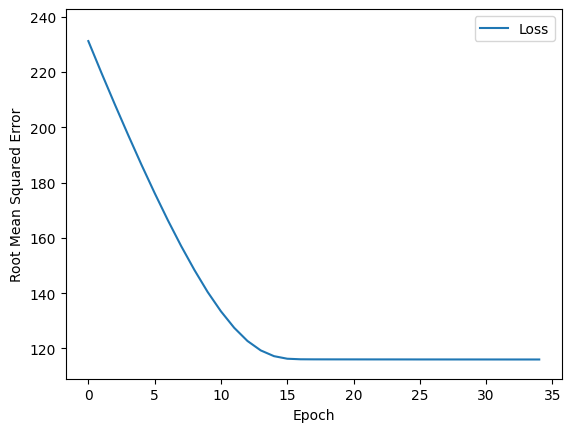


: Evaluate the new model against the test set:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12351.9932 - root_mean_squared_error: 111.0857


[12822.1435546875, 113.23490142822266]

In [39]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the feature_cross_feature_layer:
my_model = create_model(list(inputs.values()), list(outputs.values()), learning_rate)


# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

# Print out the model summary.
my_model.summary(expand_nested=True)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

!!!!!!!!!!  test, features: {'longitude': array([-121.33, -118.15, -117.93, ..., -121.92, -118.69, -118.08]), 'latitude': array([37.97, 34.06, 33.67, ..., 36.56, 34.21, 33.91]), 'housing_median_age': array([43., 28., 27., ..., 39., 10., 36.]), 'total_rooms': array([1511., 3855., 3512., ..., 2144., 3663., 1551.]), 'total_bedrooms': array([292., 922., 472., ..., 538., 409., 297.]), 'population': array([ 721., 2517., 1391., ...,  749., 1179., 1100.]), 'households': array([320., 874., 481., ..., 419., 371., 322.]), 'median_income': array([ 3.5703,  3.505 ,  8.1001, ...,  2.7039, 12.542 ,  5.1187]), 'median_house_value': array([ 87.4  , 204.3  , 336.5  , ..., 364.   , 500.001, 168.1  ])}
!!!!!!!!!!  test, label: [ 87.4   204.3   336.5   ... 364.    500.001 168.1  ]
Epoch 1/35
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 55730.0859 - root_mean_squared_error: 236.0555
Epoch 2/35
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 50173.7969 - root_mean_squared_error: 223.9498
Epoch 3/35
17

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ latitude            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ longitude           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discretization_lat… │ (None, 1)         │          0 │ latitude[0][0]    │
│ (Discretization)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discretization_lon… │ (None, 1)         │          0 │ longitude[0][0]   │
│ (Discretization)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_latitude_lon… │ (None, 575)       │          0 │ discretization_l… │
│ (HashedCrossing)    │                   │            │ discretization_l… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer (Dense) │ (None, 1)         │        576 │ cross_latitude_l… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,154 (4.51 KB)

 Trainable params: 576 (2.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 578 (2.26 KB)

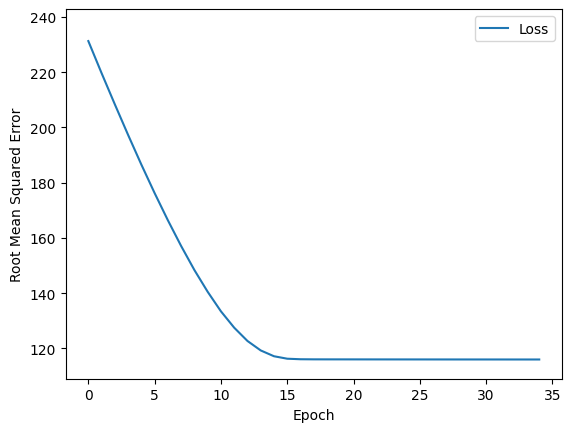


: Evaluate the new model against the test set:
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12348.2617 - root_mean_squared_error: 111.0688


[12812.5810546875, 113.19267272949219]

In [37]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the feature_cross_feature_layer:
my_model = create_model(list(inputs.values()), list(outputs.values()), learning_rate)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

# Print out the model summary.
my_model.summary(expand_nested=True)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## Task 4: Did the feature cross outperform buckets?

Compare the model's `root_mean_squared_error` values for the two representations (buckets vs. feature cross)?  
Which model produced lower losses?  
是的，將這些特徵表示為特徵交叉產生的損失值比用桶表示的損失值(RMSE)低得多。  


## Task 5: Adjust the resolution of the feature cross

Return to the code cell in the "Represent location as a feature cross" section. Notice that `resolution_in_degrees` is set to 1.0. Therefore, each cell represents an area of 1.0 degree of latitude by 1.0 degree of longitude, which corresponds to a cell of 110 km by 90 km.  This resolution defines a rather large neighborhood.  
每個單元代表的區域是 1.0 度緯度乘以 1.0 度經度，對應於 110 公里乘 90 公里的區域。  

Experiment with `resolution_in_degrees` to answer the following questions:

  1. What value of `resolution_in_degrees` produces the best results (lowest loss value)?  
  大約 0.4 度的解析度提供了最好的結果。  
  因為 0.4 度的解析度平衡了特徵交叉單元的數量和每個單元中的樣本數量。這樣的解析度能夠捕捉到較細的地理位置特徵，同時確保每個單元有足夠的樣本數量進行學習。

  2. Why does loss increase when the value of `resolution_in_degrees` drops below a certain value?  
  當解析度低於大約 0.4 度時，損失會增加，因為數據集中每個單元的樣本數量不足以準確地預測這些單元的價格。  
  因為解析度過高（單元過小）時，每個單元中的樣本數量會顯著減少。這導致每個單元內的數據不足以支持準確的模型訓練，從而增加了預測誤差。
  

  3. What feature (that does not exist in the California Housing Dataset) would be a better proxy for location than latitude X longitude.  
  郵政編碼會是一個比緯度和經度更好的特徵，前提是數據集中每個郵政編碼區域的樣本數量足夠多。  
  郵政編碼通常對應於更自然和更精確的地理區域劃分，可以更準確地捕捉到地理位置對房價的影響。相比於緯度和經度的網格劃分，郵政編碼可以直接反映出鄰里和社區特徵，從而提供更準確的預測。
